### Imports

In [48]:
import os
import yaml
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb


### Load config.yaml

In [49]:
#get config file
config_path = os.path.join(project_root, "config.yaml")

def load_config():
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"ERROR: config.yaml not found at {config_path}")
    else:
        with open(config_path, "r") as file:
            config = yaml.safe_load(file)
    return config

# Test load
config = load_config()
print("Config loaded successfully!")

Config loaded successfully!


### Import `aggregated_full.csv` Dataset and Select features from config

In [50]:
READ_FOLDER_PATH = '../data/processed/'

df = pd.read_csv(READ_FOLDER_PATH+'aggregated_full.csv')

print(df.shape[0])
pd.set_option("display.max_colwidth", None) 

context_features = config.get("features",{}).get("context_features",[])
selected_features = config.get("features",{}).get("selected_features",[])
constructed_features = config.get("features",{}).get("constructed_features",[])
target_variables =config.get("features",{}).get("target_variables",[])

if constructed_features is None:
    constructed_features = []

selected_columns = context_features + selected_features + constructed_features + target_variables
df = df[selected_columns]

#Drop NaN and inf rows:
df_selected = df.copy()
df_selected.loc[:, :] = df.replace([np.inf, -np.inf], np.nan)
df_selected = df_selected.dropna()
df_selected

9074


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,game_state_80,...,home_urgency_to_attack,away_urgency_to_attack,home_momentum_to_attack,away_momentum_to_attack,attack_intensity,defensive_pressure,home_corner_diff,away_corner_diff,corner_diff,target
0,UFot0hit/,2011-08-05,2012,D1,germany,Borussia Dortmund,Hamburg SV,3-1,3-1,h,...,0.000,0.067,0.000,0.067,0,-2,0,1,1,1
1,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,a,...,0.424,0.000,-0.424,-0.000,0,-3,1,1,2,1
2,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,a,...,0.645,0.000,1.935,-0.000,3,0,3,1,4,1
3,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,h,...,0.000,0.290,0.000,0.000,0,-2,1,3,4,1
4,M7PhlM2C/,2011-08-06,2012,F1,france,Brest,Evian Thonon Gaillard,2-2,2-2,d,...,0.627,0.373,2.508,0.000,0,-1,3,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,vJy048Er/,2017-01-22,2017,I1,italy,Empoli,Udinese,0-0,1-0,d,...,0.505,0.495,-0.505,0.000,0,0,1,0,1,1
9070,xAkY8l6R/,2017-01-22,2017,I1,italy,Genoa,Crotone,2-2,2-2,d,...,0.802,0.198,-0.802,-0.396,0,0,2,0,2,1
9071,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,h,...,0.000,0.050,0.000,0.050,1,-2,1,0,1,1
9072,xY7uZwOI/,2017-01-22,2017,F1,france,AS Monaco,Lorient,4-0,4-0,h,...,0.000,0.000,0.000,0.000,0,0,0,0,0,0


### Plot correlation heatmap (for selected features)

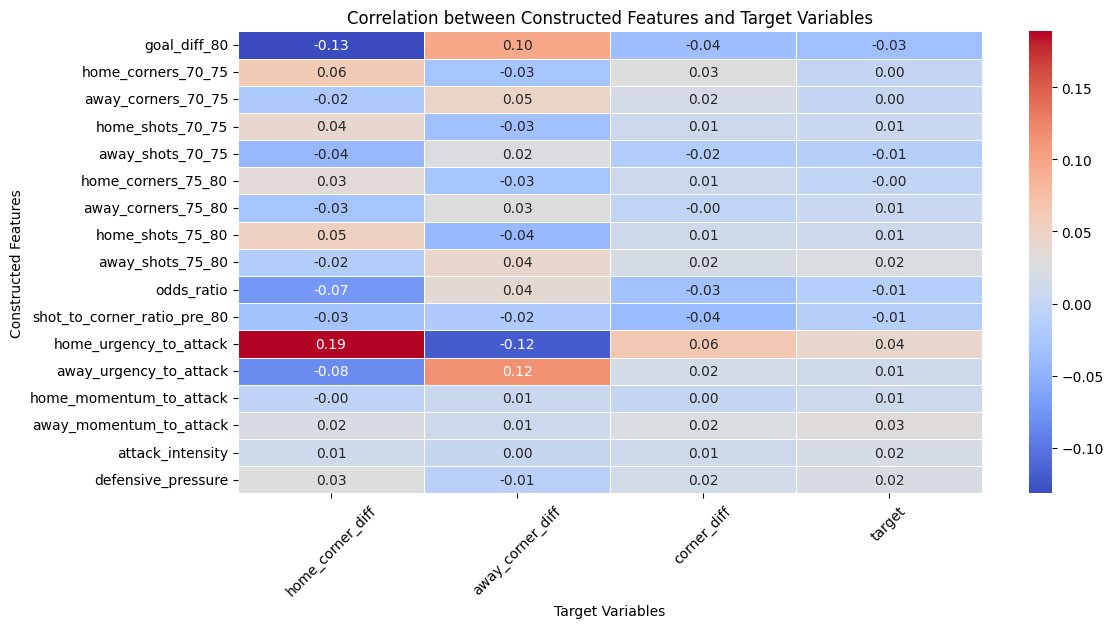

In [51]:
#Corelation matrix:
correlation_matrix = df_selected[selected_features + constructed_features + target_variables].corr()
correlation_with_target = correlation_matrix[target_variables].drop(target_variables, axis=0)

# Plot correlation heatmap:
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_with_target, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Target Variables")
plt.ylabel("Constructed Features")
plt.title("Correlation between Constructed Features and Target Variables")
plt.show()

## Utility Funcs for Model Training:

- `Initialise_model`
    - Initialises classifier model depending on input model type

- `Grid_search`
    - Performs GridSearchCV for hyperparameter tuning depending on input model

- `Get_feature_importance`
    - Prints the top 8 and bottom 5 features

- `Optimise_threshold`
    - Optimises threshold based on Precision-Recall
    - Our aim is to increase Precision-Recall (more importantly precision), since we want to increase the likelihood of winning a 1+ corners at 80min bet -> prediciting the number of 1's correctly as important, i.e. when we do place a bet, we make sure we have a high chance of winning.
    - Therefore, I performed threshold adjustament to try and maximise precision (but ensure recall is at least 10% to avoid precision=1)

In [52]:
def initialise_model(model_name, hyperparameters):
    if model_name == "random_forest":
        return RandomForestClassifier(**hyperparameters, random_state=42, class_weight="balanced")
    elif model_name == "logistic_regression":
        return LogisticRegression(**hyperparameters, random_state=42, class_weight="balanced")
    elif model_name == "svc":
        return SVC(probability=True, **hyperparameters, random_state=42, class_weight="balanced")
    elif model_name == "xgboost":
        return xgb.XGBClassifier(**hyperparameters, random_state=42)
    else:
        raise ValueError(f"Model, {model_name}, is not supported.")
    
def grid_search(model_name, model, X_train, y_train):
    """
    Performs Grid Search for hyperparameter tuning depending on input model:
    """
    if model_name == "random_forest":
        param_grid = param_grid or {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2,4],
            'bootstrap': [True, False]
        }

    elif model_name == "logistic_regression":
        param_grid = param_grid or {
            'C': [0.1, 1, 10,100],
            'solver': ['liblinear', 'saga']
        }

    elif model_name == "svc":
        param_grid = param_grid or {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma':['scale', 'auto']
        }

    elif model_name == "xgboost":
        param_grid = param_grid or {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7],
            'subsample': [0.8,1.0]
        }

    #Score by precision:
    precision_scorer = make_scorer(precision_score, average="micro")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=precision_scorer, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Precision Score:", grid_search.best_score_)

    #Use best_estimator for predictions
    best_model = grid_search.best_estimator_
    return best_model

def get_feature_importance(model, model_name, selected_features, constructed_features):
    """
    Gets feature importance (depending on model) 
    Displays top 8 + bottom 5...
    """
    # Collect all features
    all_features = selected_features + constructed_features
    
    if model_name in ["random_forest", "xgboost"]:
        importance = model.feature_importances_
    elif model_name == "logistic_regression":
        importance = model.coef_[0]
    elif model_name == "svc":
        #For SVC, feature importance is only available for linear
        if hasattr(model, 'coef_'):
            importance = model.coef_[0]
        else:  #Else, if its non-linear... set all importance to zero:
            importance = np.zeros(len(all_features)) 
    else:
        raise ValueError(f"Invalid model input: {model_name}")
    
    # Display feature importance
    feature_importances = pd.DataFrame({
        'Feature': all_features,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    top_features = feature_importances.head(8) # Get top 8
    bottom_features = feature_importances.tail(5) # Get bottom 5
    
    # Combine the top 8 and bottom 5 features
    combined_features = pd.concat([top_features, bottom_features])

    return combined_features

def optimise_threshold(y_pred_val, y_val):
    #--- Threshold Maximisation ---
    thresholds = np.linspace(0.5, 0.95, 20) #test thresholds from 0.5 to 0.95
    results = []
    for t in thresholds:
        y_pred_t =(y_pred_val>=t).astype(int)
        precision_t= precision_score(y_val, y_pred_t, zero_division=1)  
        recall_t= recall_score(y_val, y_pred_t)
        
        if recall_t>=0.1: #only take results where recall >= 0.1
            results.append((t, precision_t, recall_t))

    #results as table
    print("\n### Precision-Recall Tradeoff at Different Thresholds ###\n") 
    print(f"{'Threshold':<12}{'Precision':<12}{'Recall':<12}") 
    print("-"*36)  
    for t, p, r in results:
        print(f"{t:<12.2f}{p:<12.4f}{r:<12.4f}")
    
    best_threshold = max(results, key=lambda x: x[1])
    optimal_threshold = round(best_threshold[0],3)
    print("\n### Recommended Threshold for Maximum Precision ###")
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Expected Precision: {best_threshold[1]:.4f}")
    print(f"Expected Recall: {best_threshold[2]:.4f}")

    return optimal_threshold

## Plotting Funcs 

- `Plot_scatter` - Plot scatter graph to visualise our spread of predictions & how the threshold binarises them. 

- `Plot_roc_and_prc` (calls `plot_roc_curve` and `plot_precision_recall_curve`)

In [53]:
def plot_scatter(y_probs_final, y_test_final, optimal_threshold, model_name):
    # Scatter plot: target vs predicted probabilities
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_probs_final)), y_probs_final,c=y_test_final,cmap='coolwarm',alpha=0.7,label='Predicted Probability')
    plt.axhline(optimal_threshold, color='red', linestyle='dashed',linewidth=2,label=f'Threshold = {optimal_threshold:.2f}')
    class_0 =mlines.Line2D([], [],color='blue',marker='o',linestyle='None', markersize=8, alpha=0.7, label='Target: No 1+ Corners')
    class_1=mlines.Line2D([], [],color='red', marker='o',linestyle='None',markersize=8,alpha=0.7, label='Target: 1+ Corners')
    plt.xlabel('Match Index')
    plt.ylabel('Predicted probability of 1+ corners')
    plt.title(f'{model_name} - Predicted Probability vs Actual Target')
    plt.legend(handles=[class_0, class_1,plt.Line2D([], [],color='grey',linestyle='dashed',linewidth=2,label='Threshold')])
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, model_name, ax):
    ax.plot(fpr,tpr, color='b',lw=2, label=f'ROC curve (area ={roc_auc:.2f})')
    ax.plot([0,1], [0,1], color='gray', linestyle='--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall,pr_auc, model_name, ax):
    ax.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend(loc="lower left")

def plot_roc_and_prc(fpr, tpr, roc_auc, precision,recall, pr_auc,model_name):
    #Plots ROC curve and Precision-recall side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  
    plot_roc_curve(fpr, tpr, roc_auc, model_name,ax1)
    plot_precision_recall_curve(precision, recall, pr_auc, model_name,ax2)
    plt.tight_layout()
    plt.show()


# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.


-> Training random_forest...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
9                    odds_ratio    0.169633
10  shot_to_corner_ratio_pre_80    0.162847
12       away_urgency_to_attack    0.099562
11       home_urgency_to_attack    0.080990
14      away_momentum_to_attack    0.073557
16           defensive_pressure    0.068805
13      home_momentum_to_attack    0.065341
3              home_shots_70_75    0.038610
15             attack_intensity    0.025742
1            home_corners_70_75    0.022075
5            home_corners_75_80    0.021165
6            away_corners_75_80    0.019842
2            away_corners_70_75    0.019538

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7606      0.9800      
0.52        0.7602      0.9685      
0.55        0.7594      0.9570      
0.57        0.7578      0.9340      
0.59        0.7592      0

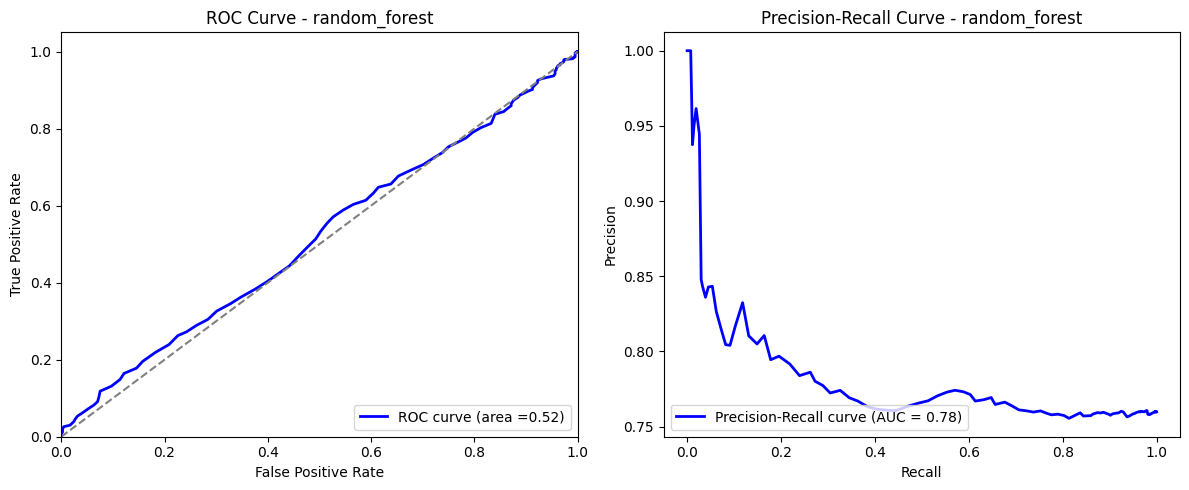


### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.25      0.90      0.39       118
           1       0.83      0.15      0.26       382

    accuracy                           0.33       500
   macro avg       0.54      0.53      0.32       500
weighted avg       0.69      0.33      0.29       500

random_forest model saved.
Predictions saved for random_forest.


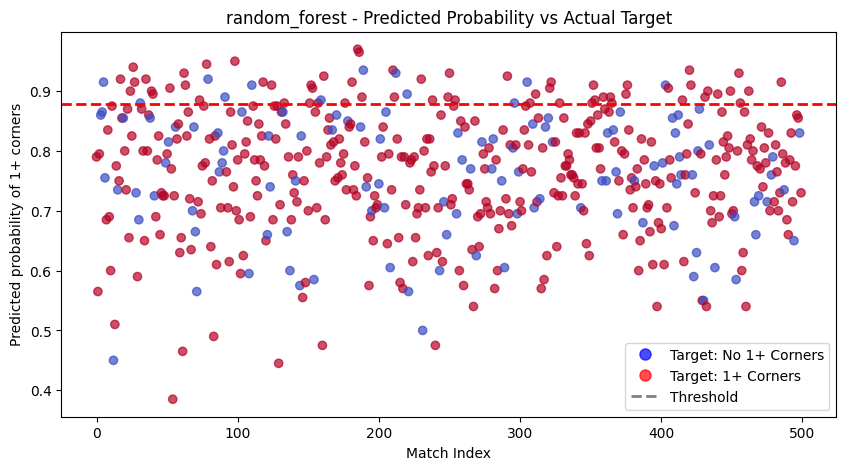


-> Training logistic_regression...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
14      away_momentum_to_attack    0.937813
13      home_momentum_to_attack    0.874073
16           defensive_pressure    0.515437
15             attack_intensity    0.370021
11       home_urgency_to_attack    0.316127
8              away_shots_75_80    0.229461
7              home_shots_75_80    0.125043
3              home_shots_70_75    0.121965
4              away_shots_70_75   -0.161954
5            home_corners_75_80   -0.229813
10  shot_to_corner_ratio_pre_80   -0.332390
9                    odds_ratio   -0.395357
0                  goal_diff_80   -0.592319

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7808      0.5249      
0.52        0.7836      0.3308      
0.55        0.7881      0.1627      

### Recommended Threshold for Maximum Precision ###
Opt

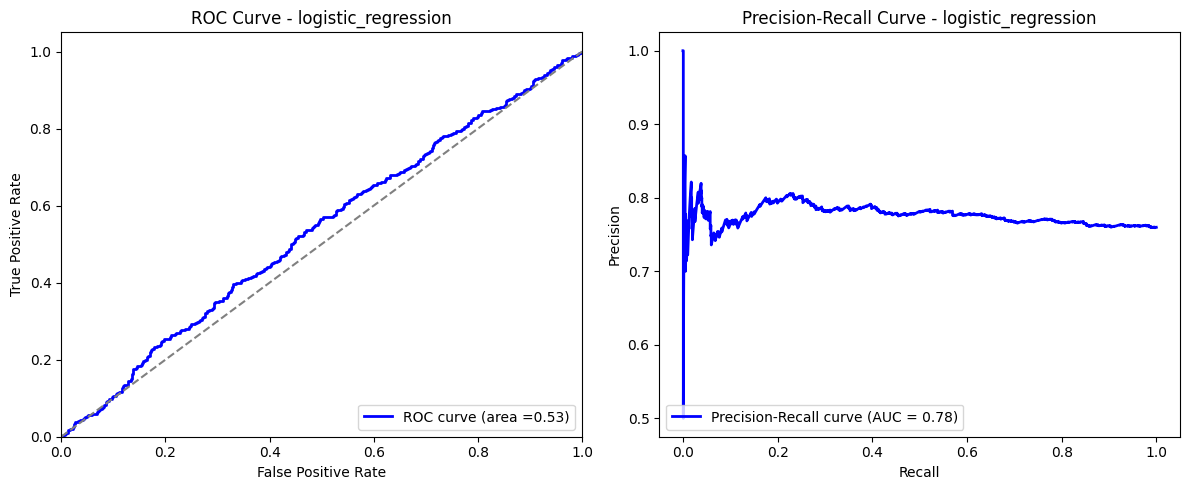


### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.24      0.86      0.37       118
           1       0.77      0.14      0.24       382

    accuracy                           0.31       500
   macro avg       0.51      0.50      0.31       500
weighted avg       0.65      0.31      0.27       500

logistic_regression model saved.
Predictions saved for logistic_regression.


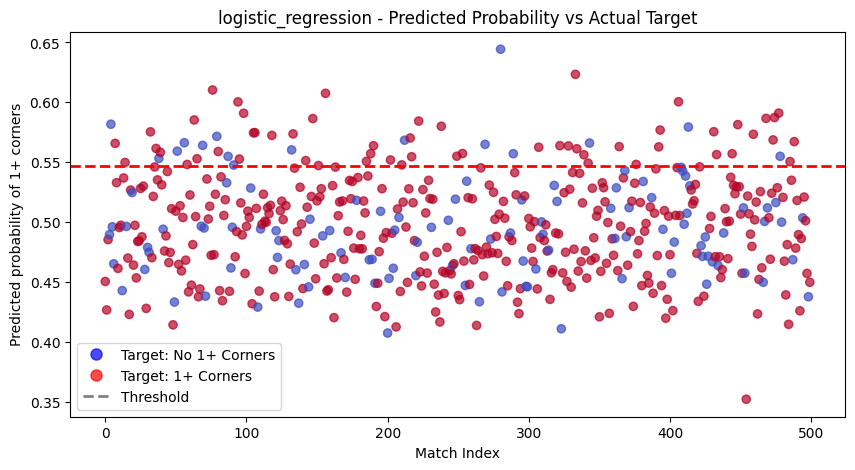


-> Training svc...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
0                  goal_diff_80         0.0
9                    odds_ratio         0.0
15             attack_intensity         0.0
14      away_momentum_to_attack         0.0
13      home_momentum_to_attack         0.0
12       away_urgency_to_attack         0.0
11       home_urgency_to_attack         0.0
10  shot_to_corner_ratio_pre_80         0.0
5            home_corners_75_80         0.0
4              away_shots_70_75         0.0
3              home_shots_70_75         0.0
2            away_corners_70_75         0.0
16           defensive_pressure         0.0

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7598      1.0000      
0.52        0.7598      1.0000      
0.55        0.7598      1.0000      
0.57        0.7598      1.0000      
0.59        0.7598      1.0000     

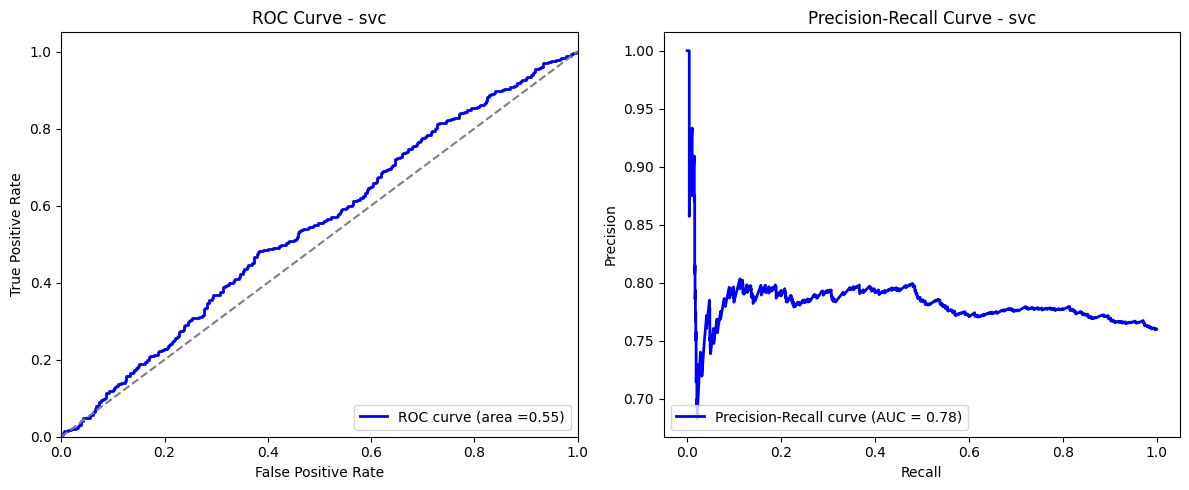


### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.25      0.85      0.39       118
           1       0.83      0.22      0.35       382

    accuracy                           0.37       500
   macro avg       0.54      0.53      0.37       500
weighted avg       0.69      0.37      0.36       500

svc model saved.
Predictions saved for svc.


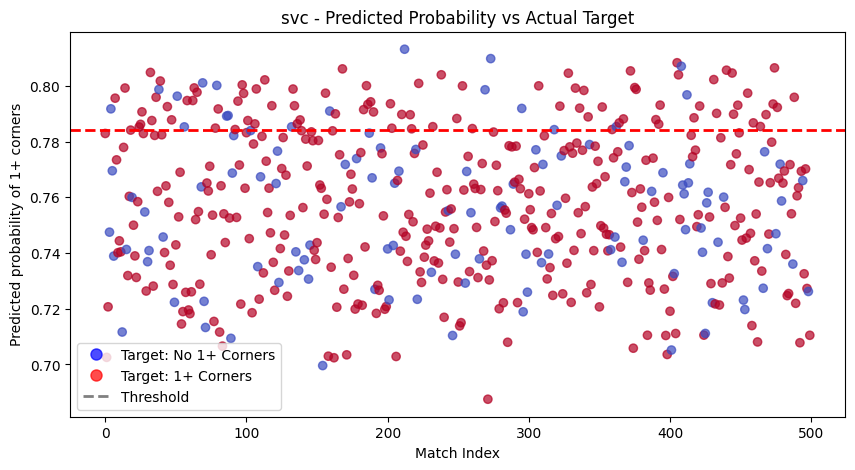


-> Training xgboost...

### Top 8 and Bottom 5 Feature Importance ###
                    Feature  Importance
12   away_urgency_to_attack    0.069763
6        away_corners_75_80    0.068497
14  away_momentum_to_attack    0.065518
1        home_corners_70_75    0.064535
5        home_corners_75_80    0.063904
0              goal_diff_80    0.062697
9                odds_ratio    0.059724
15         attack_intensity    0.059206
11   home_urgency_to_attack    0.054423
3          home_shots_70_75    0.052668
2        away_corners_70_75    0.052510
16       defensive_pressure    0.050707
8          away_shots_75_80    0.048164

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7625      0.9931      
0.52        0.7636      0.9916      
0.55        0.7629      0.9854      
0.57        0.7627      0.9793      
0.59        0.7627      0.9670      
0.62        0.7631      0.9470      
0.64        0

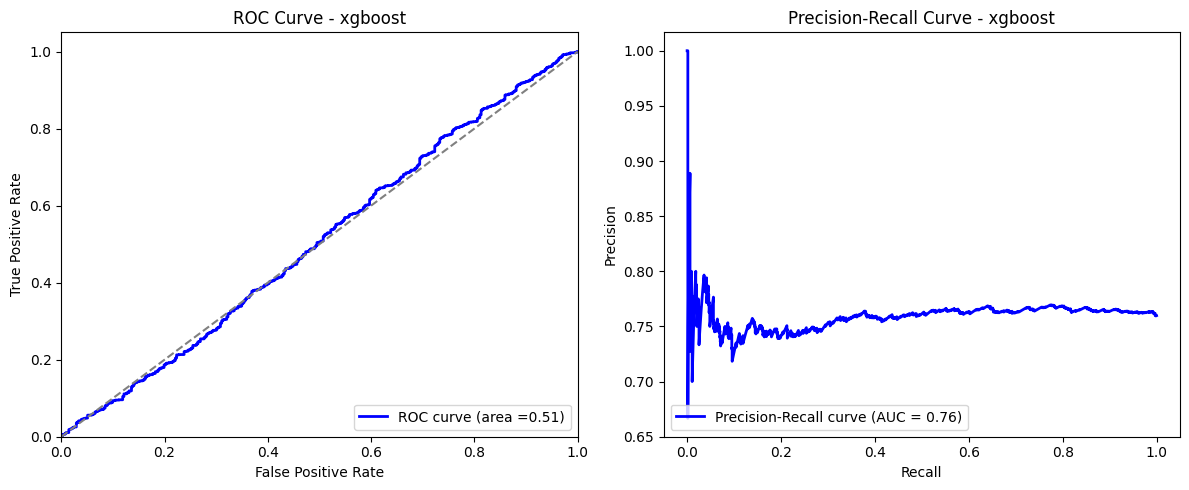


### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.29      0.25      0.27       118
           1       0.78      0.80      0.79       382

    accuracy                           0.67       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.66      0.67      0.67       500

xgboost model saved.
Predictions saved for xgboost.


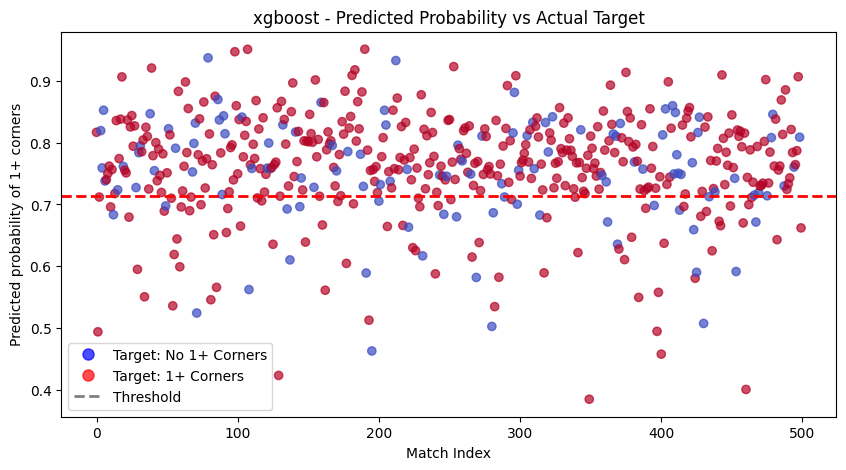

In [54]:
def run_classification_pipeline(config, df, selected_features, constructed_features, target_variable="target"):
    #Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    #Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data["target"],
        test_size=0.2,
        random_state=42,
        stratify=train_data["target"]
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test =test_data["target"]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled =scaler.transform(X_val)
    X_test_scaled =scaler.transform(X_test)

    # --- MODEL TRAINING LOOP ---
    # Train and evaluate each model from the config
    models_to_train = config['model']['classification']['models']
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")
    
        # Get the hyperparameters for the model
        hyperparameters = config["model"]["classification"]["hyperparameters"].get(model_name, {})
        do_grid_search=config["model"]["classification"].get("grid_search", False)

        # --- STEP 1: Initialise the model
        model = initialise_model(model_name, hyperparameters)

        # --- STEP 2: Select Scaled or Unscaled Data ---
        if model_name in ["logistic_regression", "svc", "xgboost"]:
            X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
        
        # --- STEP 3: Grid Search (optional) ---
        if do_grid_search:
            optimal_model = grid_search(model_name, model, X_train, y_train)
        else:
            model.fit(X_train, y_train)
            optimal_model = model

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = optimal_model.predict_proba(X_val)[:, 1]

        #Display Feature Importance
        feature_importances = get_feature_importance(optimal_model, model_name, selected_features, constructed_features)
        print("\n### Top 8 and Bottom 5 Feature Importance ###")
        print(feature_importances)

        # --- STEP 5: Precision-Recall Threshold Optimisation ---
        optimal_threshold = optimise_threshold(y_pred_val, y_val)

        # --- STEP 6: Model Evaluation ---
        y_pred_threshold =(y_pred_val >= optimal_threshold).astype(int)
        print(f"\n### Classification Report (threshold={optimal_threshold}):\n") 
        print(classification_report(y_val, y_pred_threshold))

        # --- STEP 7: Plot ROC and Precision-Recall curves ---
        fpr,tpr,_ =roc_curve(y_val, y_pred_val)
        roc_auc =roc_auc_score(y_val, y_pred_val)
        precision,recall,_ =precision_recall_curve(y_val, y_pred_val)
        pr_auc=auc(recall, precision)
        plot_roc_and_prc(fpr, tpr, roc_auc,precision,recall, pr_auc,model_name)

        # --- STEP 8: Test on test set (last 500 rows) ---
        # Predict on the final test data (last 500 rows)
        y_probs_final =optimal_model.predict_proba(X_test)[:, 1]
        y_pred_final=(y_probs_final >=optimal_threshold).astype(int)

        #Evaluate on the last 500 rows (final simulation)
        print("\n### Prediction on last 500 rows: ###")
        print(classification_report(y_test, y_pred_final))

        # --- STEP 9: Save Model ---
        model_dir = "../models" 
        if not os.path.exists(model_dir): # Ensure the directory exists
            os.makedirs(model_dir)
        # Save the model
        joblib.dump(optimal_model, os.path.join(model_dir, f"{model_name.replace(' ', '_').lower()}_model.pkl"))
        print(f"{model_name} model saved.")

        # --- STEP 10: Save Predictions ---
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_final,
            'actual_result': y_test
        })
        results_df.to_csv(f"{model_name.replace(' ', '_').lower()}_predictions.csv", index=False)
        print(f"Predictions saved for {model_name}.")

        # --- STEP 11: Plot Scatter Graph ---
        plot_scatter(y_probs_final, y_test, optimal_threshold, model_name)


''' 
*****----------------------------------------*****
MAIN training and testing loop for classification
*****----------------------------------------*****
 '''
run_classification_pipeline(config, df_selected, selected_features, constructed_features)
